In [7]:
"""
Explicación general (cómo funciona este notebook)

Resumen rápido:
1) Se generan muchos colores candidatos en HSL (tono aleatorio, saturación alta, luminosidad media).
2) Se convierten a RGB y a Lab; en Lab la distancia (ΔE) se correlaciona mejor con diferencia visual.
3) Se seleccionan n colores con muestreo "maximin": cada nuevo color es el que está más lejos de los ya elegidos,
   evitando colores parecidos y maximizando la separación perceptual entre todos.
4) Se comprueba el contraste de cada color contra un fondo (bg_hex). Si es bajo, se ajusta la L (luminosidad)
   para mejorar legibilidad sin distorsionar demasiado el color.
5) Para cada color se guarda: hex, rgb (0-255), lab, el código Aegis para ASS/SSA, el contraste y la distancia mínima
   a los demás (min ΔE).
6) La función show_palette dibuja bloques de color, calcula localmente si el texto debe ser negro o blanco, y muestra
   debajo el HEX, la info (ΔE y contraste) y el código Aegis.

Entradas clave:
- n: cuántos colores distintos quieres.
- seed: semilla para resultados reproducibles.
- candidates: cuántos candidatos se generan antes de seleccionar los mejores.
- bg_hex: color de fondo frente al que se mide el contraste.
- wcag_threshold: umbral mínimo de contraste deseado.
- fixed_hex: lista opcional de colores forzados ("semillas") que se incluyen sí o sí.
- adjust_fixed: si True, permite ajustar L de los fijos para cumplir contraste.

Salidas:
- Una lista (paleta) de n diccionarios con la info de cada color, lista para usarse y visualizarse.
"""

from __future__ import annotations
from typing import TypedDict

# Definición de tipos
RGB255 = tuple[int, int, int]
Lab = tuple[float, float, float]

class PaletteColor(TypedDict):
    hex: str
    rgb: RGB255
    lab: Lab
    aegis: str
    contrast_vs_bg: float
    min_delta_e: float | None

# Código completo listo para pegar en un notebook
# - Genera paleta (maximin en Lab)
# - Cada color tiene campo 'aegis' con el código ASS: e.g. {\c&HBBGGRR&}
# - Imprime y muestra figura con swatches (texto HEX debajo)
# - La figura calcula localmente el color de la etiqueta (negro/blanco) para legibilidad

import random, math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from math import sqrt, pow, ceil

# --- Force matplotlib to use the default (light) style and explicit light facecolors ---
# This prevents some backends or environment settings from showing dark-mode plots.
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.edgecolor': 'black'
})

# ------------------- utilidades de color -------------------
def clamp01(x: float) -> float:
    """Limita un valor al rango [0,1].

    :param x: Valor a recortar.
    :type x: float
    :return: Valor dentro de [0,1].
    :rtype: float
    """
    return max(0.0, min(1.0, x))

def rgb_frac_to_hex(rgb: tuple[float, float, float]) -> str:
    """Convierte componentes RGB fraccionales (0-1) a cadena hexadecimal #RRGGBB.

    :param rgb: Tripleta RGB fraccional.
    :type rgb: tuple[float, float, float]
    :return: Cadena hexadecimal en formato #RRGGBB.
    :rtype: str
    """
    return '#{:02x}{:02x}{:02x}'.format(int(clamp01(rgb[0])*255+0.5),
                                        int(clamp01(rgb[1])*255+0.5),
                                        int(clamp01(rgb[2])*255+0.5))

def hex_to_rgb_frac(h: str) -> tuple[float, float, float]:
    """Convierte una cadena #RRGGBB a componentes RGB fraccionales.

    :param h: Cadena hexadecimal del color.
    :type h: str
    :return: Tripleta RGB fraccional (cada componente en [0,1]).
    :rtype: tuple[float, float, float]
    """
    h = h.lstrip('#')
    r = int(h[0:2], 16)/255.0
    g = int(h[2:4], 16)/255.0
    b = int(h[4:6], 16)/255.0
    return (r, g, b)

def srgb_to_linear(c: float) -> float:
    """Convierte componente sRGB a espacio lineal.

    :param c: Componente sRGB (0-1).
    :type c: float
    :return: Componente lineal.
    :rtype: float
    """
    return c/12.92 if c <= 0.04045 else pow((c+0.055)/1.055, 2.4)

def linear_to_srgb(c: float) -> float:
    """Convierte componente lineal a sRGB.

    :param c: Componente lineal (puede estar fuera de [0,1] antes de clamping).
    :type c: float
    :return: Componente sRGB.
    :rtype: float
    """
    return 12.92*c if c <= 0.0031308 else 1.055*pow(c, 1/2.4)-0.055

def rgb_to_xyz(rgb: tuple[float, float, float]) -> tuple[float, float, float]:
    """Convierte RGB fraccional a espacio XYZ (D65).

    :param rgb: Tripleta RGB fraccional.
    :type rgb: tuple[float, float, float]
    :return: Tripleta XYZ.
    :rtype: tuple[float, float, float]
    """
    r,g,b = rgb
    r_l = srgb_to_linear(r); g_l = srgb_to_linear(g); b_l = srgb_to_linear(b)
    x = r_l*0.4124564 + g_l*0.3575761 + b_l*0.1804375
    y = r_l*0.2126729 + g_l*0.7151522 + b_l*0.0721750
    z = r_l*0.0193339 + g_l*0.1191920 + b_l*0.9503041
    return (x,y,z)

def xyz_to_rgb(xyz: tuple[float, float, float]) -> tuple[float, float, float]:
    """Convierte XYZ (D65) a RGB fraccional.

    :param xyz: Tripleta XYZ.
    :type xyz: tuple[float, float, float]
    :return: Tripleta RGB fraccional (sin clamping).
    :rtype: tuple[float, float, float]
    """
    x,y,z = xyz
    r_l = x* 3.2404542 + y*-1.5371385 + z*-0.4985314
    g_l = x*-0.9692660 + y*1.8760108 + z*0.0415560
    b_l = x* 0.0556434 + y*-0.2040259 + z*1.0572252
    return (linear_to_srgb(r_l), linear_to_srgb(g_l), linear_to_srgb(b_l))

def xyz_to_lab(xyz: tuple[float, float, float]) -> Lab:
    """Convierte XYZ a CIE Lab.

    :param xyz: Tripleta XYZ.
    :type xyz: tuple[float, float, float]
    :return: Tripleta Lab (L,a,b).
    :rtype: tuple[float, float, float]
    """
    xr, yr, zr = 0.95047, 1.00000, 1.08883
    x,y,z = xyz
    def f(t: float) -> float:
        return pow(t, 1/3) if t > 0.008856 else 7.787*t + 16.0/116.0
    fx = f(x/xr); fy = f(y/yr); fz = f(z/zr)
    L = 116.0*fy - 16.0
    a = 500.0*(fx - fy)
    b = 200.0*(fy - fz)
    return (L,a,b)

def lab_to_xyz(lab: Lab) -> tuple[float, float, float]:
    """Convierte CIE Lab a XYZ.

    :param lab: Tripleta Lab (L,a,b).
    :type lab: tuple[float, float, float]
    :return: Tripleta XYZ.
    :rtype: tuple[float, float, float]
    """
    L,a,b = lab
    fy = (L+16.0)/116.0
    fx = a/500.0 + fy
    fz = fy - b/200.0
    def f_inv(t: float) -> float:
        return t**3 if t**3 > 0.008856 else (t - 16.0/116.0)/7.787
    xr, yr, zr = 0.95047, 1.00000, 1.08883
    x = xr * f_inv(fx)
    y = yr * f_inv(fy)
    z = zr * f_inv(fz)
    return (x,y,z)

def rgb_to_lab(rgb: tuple[float, float, float]) -> Lab:
    """Convierte RGB fraccional directamente a CIE Lab.

    :param rgb: Tripleta RGB fraccional.
    :type rgb: tuple[float, float, float]
    :return: Tripleta Lab.
    :rtype: tuple[float, float, float]
    """
    return xyz_to_lab(rgb_to_xyz(rgb))

def lab_to_rgb(lab: Lab) -> tuple[float, float, float]:
    """Convierte Lab a RGB fraccional.

    :param lab: Tripleta Lab.
    :type lab: tuple[float, float, float]
    :return: Tripleta RGB fraccional.
    :rtype: tuple[float, float, float]
    """
    return xyz_to_rgb(lab_to_xyz(lab))

def hsl_to_rgb(h_deg: float, s: float, l: float) -> tuple[float, float, float]:
    """Convierte HSL a RGB fraccional.

    :param h_deg: Tono en grados.
    :type h_deg: float
    :param s: Saturación (0-1).
    :type s: float
    :param l: Luminosidad (0-1).
    :type l: float
    :return: Tripleta RGB fraccional.
    :rtype: tuple[float, float, float]
    """
    h = (h_deg % 360) / 360.0
    if s == 0:
        return (l,l,l)
    def hue2rgb(p: float, q: float, t: float) -> float:
        if t < 0: t += 1
        if t > 1: t -= 1
        if t < 1/6: return p + (q-p)*6*t
        if t < 1/2: return q
        if t < 2/3: return p + (q-p)*(2/3 - t)*6
        return p
    q = l*(1+s) if l < 0.5 else l + s - l*s
    p = 2*l - q
    r = hue2rgb(p, q, h + 1/3)
    g = hue2rgb(p, q, h)
    b = hue2rgb(p, q, h - 1/3)
    return (r,g,b)

def relative_luminance(rgb: tuple[float, float, float]) -> float:
    """Calcula luminancia relativa (WCAG) de un color RGB fraccional.

    :param rgb: Tripleta RGB fraccional.
    :type rgb: tuple[float, float, float]
    :return: Luminancia relativa.
    :rtype: float
    """
    def f(c: float) -> float:
        c = clamp01(c)
        return c/12.92 if c <= 0.03928 else ((c+0.055)/1.055)**2.4
    r,g,b = rgb
    return 0.2126*f(r) + 0.7152*f(g) + 0.0722*f(b)

def contrast_ratio(rgb1: tuple[float, float, float], rgb2: tuple[float, float, float]) -> float:
    """Calcula el ratio de contraste entre dos colores (WCAG 2.0).

    :param rgb1: Primer color RGB fraccional.
    :type rgb1: tuple[float, float, float]
    :param rgb2: Segundo color RGB fraccional.
    :type rgb2: tuple[float, float, float]
    :return: Ratio de contraste (>=1.0).
    :rtype: float
    """
    L1 = relative_luminance(rgb1); L2 = relative_luminance(rgb2)
    L_high, L_low = max(L1,L2), min(L1,L2)
    return (L_high + 0.05) / (L_low + 0.05)

def hex_to_aegis_bgr(hexstr: str) -> str:
    """Convierte '#RRGGBB' a cadena 'BBGGRR' para código Aegis ASS.

    :param hexstr: Cadena hexadecimal del color.
    :type hexstr: str
    :return: Cadena 'BBGGRR'.
    :rtype: str
    """
    h = hexstr.lstrip('#')
    if len(h) != 6:
        h = (h + "000000")[:6]
    rr = h[0:2].upper()
    gg = h[2:4].upper()
    bb = h[4:6].upper()
    bgr = bb + gg + rr
    return bgr

def generate_palette(
    n: int,
    seed: int | None = None,
    candidates: int = 800,
    bg_hex: str = '#ffffff',
    wcag_threshold: float = 4.5,
    fixed_hex: list[str] | None = None,
    adjust_fixed: bool = True,
) -> list[PaletteColor]:
    """Genera una paleta de colores perceptualmente separados usando muestreo maximin.

    :param n: Número de colores deseados (incluye los fijos si se proporcionan).
    :param seed: Semilla para reproducibilidad.
    :param candidates: Número de candidatos HSL previos al muestreo maximin.
    :param bg_hex: Color de fondo para evaluar contraste (#RRGGBB).
    :param wcag_threshold: Umbral mínimo de contraste; si no se alcanza se ajusta L.
    :param fixed_hex: Lista de colores '#RRGGBB' que se incluirán sí o sí.
    :param adjust_fixed: Si True, permite ajustar L de los fijos para intentar cumplir contraste.
    :return: Lista de colores con metadatos.
    """
    random.seed(seed)

    # Normalizar y deduplicar fijos preservando orden
    fixed_hex = fixed_hex or []
    seen: set[str] = set()
    fixed_norm: list[str] = []
    for h in fixed_hex:
        if not h:
            continue
        h_norm = '#' + h.lstrip('#').lower()
        if len(h_norm) != 7:
            continue
        if h_norm not in seen:
            seen.add(h_norm)
            fixed_norm.append(h_norm)

    m_fixed = min(len(fixed_norm), n)
    fixed_norm = fixed_norm[:m_fixed]
    additional = max(0, n - m_fixed)

    # Candidatos aleatorios
    cand_rgb: list[tuple[float, float, float]] = []
    for _ in range(candidates):
        h = random.random()*360.0
        s = random.uniform(0.45, 0.95)
        l = random.uniform(0.28, 0.72)
        cand_rgb.append(hsl_to_rgb(h, s, l))
    cand_lab = [rgb_to_lab(c) for c in cand_rgb]

    # Semillas: colores fijos en Lab
    fixed_rgbs: list[tuple[float, float, float]] = [hex_to_rgb_frac(h) for h in fixed_norm]
    fixed_labs: list[Lab] = [rgb_to_lab(rgb) for rgb in fixed_rgbs]

    # Selección maximin considerando fijos
    palette_idx: list[int] = []
    if additional > 0:
        if not fixed_labs:
            first = random.randrange(len(cand_rgb))
            palette_idx.append(first)
        while len(palette_idx) < additional:
            best_i: int | None = None
            best_dist = -1.0
            for i, lab in enumerate(cand_lab):
                if i in palette_idx:
                    continue
                min_to_fixed = (
                    min(
                        sqrt((lab[0]-fl[0])**2 + (lab[1]-fl[1])**2 + (lab[2]-fl[2])**2)
                        for fl in fixed_labs
                    ) if fixed_labs else float('inf')
                )
                min_to_selected = (
                    min(
                        sqrt((lab[0]-cand_lab[j][0])**2 + (lab[1]-cand_lab[j][1])**2 + (lab[2]-cand_lab[j][2])**2)
                        for j in palette_idx
                    ) if palette_idx else float('inf')
                )
                mind = min(min_to_fixed, min_to_selected)
                if mind > best_dist:
                    best_dist = mind
                    best_i = i
            if best_i is None:
                break
            palette_idx.append(best_i)

    bg_rgb = hex_to_rgb_frac(bg_hex)
    results: list[PaletteColor] = []

    def build_entry(rgbf: tuple[float, float, float], allow_adjust: bool) -> PaletteColor:
        lab = rgb_to_lab(rgbf)
        hexc = rgb_frac_to_hex(rgbf)
        cr_bg = contrast_ratio(rgbf, bg_rgb)

        # Ajuste opcional de contraste (mismo método que antes, aplicado condicionalmente)
        if allow_adjust and cr_bg < wcag_threshold:
            bg_lab = rgb_to_lab(bg_rgb)
            direction = 1 if lab[0] < bg_lab[0] else -1
            L_new = max(3, min(97, lab[0] + direction * 12.0))
            new_rgb = lab_to_rgb((L_new, lab[1], lab[2]))
            if all(0.0 <= c <= 1.0 for c in new_rgb):
                rgbf = new_rgb
                lab = rgb_to_lab(rgbf)
                hexc = rgb_frac_to_hex(rgbf)
                cr_bg = contrast_ratio(rgbf, bg_rgb)

        bgr = hex_to_aegis_bgr(hexc)
        aegis_code = r"{\c&H" + bgr + r"&}"

        r_f, g_f, b_f = rgbf
        rgb255: RGB255 = (
            int(clamp01(r_f)*255+0.5),
            int(clamp01(g_f)*255+0.5),
            int(clamp01(b_f)*255+0.5),
        )
        L, a_, b_ = lab
        lab_round: Lab = (round(L, 2), round(a_, 2), round(b_, 2))
        return PaletteColor(
            hex=hexc,
            rgb=rgb255,
            lab=lab_round,
            aegis=aegis_code,
            contrast_vs_bg=round(cr_bg,2),
            min_delta_e=None
        )

    # Añadir primero los fijos
    for rgbf in fixed_rgbs:
        results.append(build_entry(rgbf, allow_adjust=adjust_fixed))

    # Añadir seleccionados por maximin
    for i in palette_idx:
        results.append(build_entry(cand_rgb[i], allow_adjust=True))

    # Calcular min ΔE entre todos
    labs = [
        rgb_to_lab((r['rgb'][0]/255.0, r['rgb'][1]/255.0, r['rgb'][2]/255.0))
        for r in results
    ]
    for idx, r in enumerate(results):
        if len(labs) <= 1:
            r['min_delta_e'] = None
        else:
            m = min(
                sqrt((labs[idx][0]-labs[j][0])**2 + (labs[idx][1]-labs[j][1])**2 + (labs[idx][2]-labs[j][2])**2)
                for j in range(len(labs)) if j != idx
            )
            r['min_delta_e'] = round(m,2)
    return results

def show_palette(palette: list[PaletteColor], block_w: float = 1.0, block_h: float = 1.0, spacing: float = 0.4, cols: int | None = None, hex_fontsize: int = 12, info_fontsize: int = 9) -> None:
    """Dibuja la paleta con bloques y texto descriptivo.

    :param palette: Lista de colores generada por ``generate_palette``.
    :type palette: list[PaletteColor]
    :param block_w: Ancho de cada bloque.
    :type block_w: float
    :param block_h: Alto de cada bloque.
    :type block_h: float
    :param spacing: Espacio horizontal entre bloques.
    :type spacing: float
    :param cols: Número de columnas (si None usa min(n,12)).
    :type cols: int | None
    :param hex_fontsize: Tamaño de fuente para el texto HEX.
    :type hex_fontsize: int
    :param info_fontsize: Tamaño de fuente para la info secundaria.
    :type info_fontsize: int
    :return: Nada; muestra la figura.
    :rtype: None
    """
    n = len(palette)
    if cols is None:
        cols = min(n, 12)
    cols = max(1, int(cols))
    rows = math.ceil(n / cols)

    margin_y = 0.9
    margin_x = 0.6

    fig_w = cols * (block_w + spacing) + margin_x * 2
    fig_h = rows * (block_h + margin_y) + margin_y
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    try:
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
    except Exception:
        pass
    ax.set_xlim(0, cols * (block_w + spacing) + margin_x * 2)
    ax.set_ylim(0, rows * (block_h + margin_y) + margin_y)
    ax.axis('off')

    for idx, c in enumerate(palette):
        row = idx // cols
        col = idx % cols
        x = margin_x + col * (block_w + spacing)
        y = margin_y + (rows - 1 - row) * (block_h + margin_y * 0.95)

        rect = Rectangle((x, y), block_w, block_h, facecolor=c['hex'], edgecolor='none')
        ax.add_patch(rect)

        rgb_frac = (c['rgb'][0]/255.0, c['rgb'][1]/255.0, c['rgb'][2]/255.0)
        black = (0.0,0.0,0.0); white = (1.0,1.0,1.0)
        cr_black = contrast_ratio(rgb_frac, black)
        cr_white = contrast_ratio(rgb_frac, white)
        label_color = '#000000' if cr_black >= cr_white else '#ffffff'

        ax.text(
            x + block_w / 2,
            y - 0.15,
            c['hex'],
            ha='center',
            va='top',
            fontsize=hex_fontsize,
            color=label_color,
            weight='700',
            clip_on=False
        )

        info = f"ΔE≈{c['min_delta_e']}  cr:{c['contrast_vs_bg']}"
        ax.text(
            x + block_w / 2,
            y - 0.45,
            info,
            ha='center',
            va='top',
            fontsize=info_fontsize,
            color=label_color,
            clip_on=False
        )

        ax.text(
            x + block_w / 2,
            y - 0.75,
            c['aegis'],
            ha='center',
            va='top',
            fontsize=max(8, info_fontsize-1),
            color=label_color,
            clip_on=False
        )

    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.04)
    plt.show()

,hex,rgb,lab,aegis,contrast_vs_bg,min_delta_e
0,#ffff00,"(255, 255, 0)","(97.14, -21.55, 94.48)",{\c&H00FFFF&},2.97,66.28
1,#ff00ff,"(255, 0, 255)","(60.32, 98.23, -60.82)",{\c&HFF00FF&},1.02,53.36
2,#00ff00,"(0, 255, 0)","(87.73, -86.18, 83.18)",{\c&H00FF00&},2.33,66.28
3,#fe6100,"(254, 97, 0)","(61.33, 56.82, 70.72)",{\c&H0061FE&},1.05,20.35
4,#398132,"(57, 129, 50)","(48.05, -39.21, 35.57)",{\c&H328139&},1.51,55.93
5,#ff2f18,"(255, 47, 24)","(55.45, 74.16, 61.85)",{\c&H182FFF&},1.16,20.35
6,#00ffff,"(0, 255, 255)","(91.11, -48.09, -14.13)",{\c&HFFFF00&},2.55,55.36
7,#785ef0,"(120, 94, 240)","(49.84, 46.78, -70.27)",{\c&HF05E78&},1.41,53.36
8,#954a5f,"(149, 74, 95)","(41.28, 34.02, 2.34)",{\c&H5F4A95&},1.93,44.26
9,#59adf0,"(89, 173, 240)","(68.37, -5.77, -40.71)",{\c&HF0AD59&},1.32,55.36


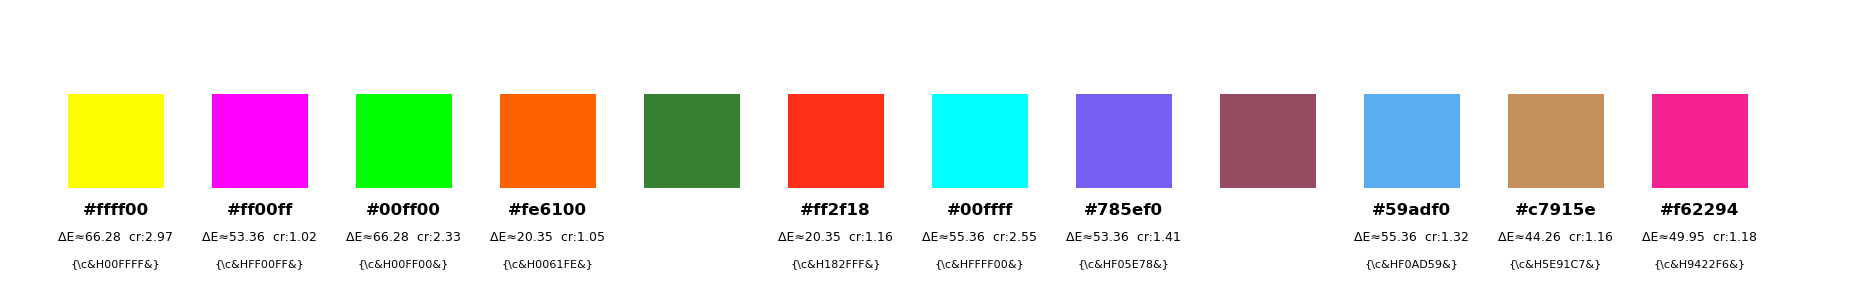

In [9]:
# ------------------- EJEMPLO DE USO -------------------
# Cambia N al tamaño de paleta que necesites
N = 12
# Colores fijos de ejemplo (opcional)
fixed = ['#FFFF00', '#FF00FF', '#00FF00', '#FE6100',
         '#59A14F', '#FF2F18', '#00FFFF', '#785EF0']
palette = generate_palette(
    n=N,
    seed=201721022,
    candidates=10000,
    bg_hex="#7f90b7",
    wcag_threshold=4.5,
    fixed_hex=fixed,          # Pasa tu lista aquí; o None para comportamiento original
    adjust_fixed=True         # Pon False si no quieres ajustar los fijos
)

# Mostrar tabla (útil en notebooks)
df = pd.DataFrame([{
    'hex': p['hex'],
    'rgb': p['rgb'],
    'lab': p['lab'],
    'aegis': p['aegis'],
    'contrast_vs_bg': p['contrast_vs_bg'],
    'min_delta_e': p['min_delta_e']
} for p in palette])
display(df)

# Mostrar figura con swatches (ajusta cols/block_w/spacing si quieres otra disposición)
show_palette(palette, block_w=1.0, block_h=1.0, spacing=0.5, cols=None, hex_fontsize=12, info_fontsize=9)